In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:28: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy import sparse


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


In [3]:
import anndata
adata = anndata.read_h5ad("../macaque_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 30302 × 36162
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH'
    var: 'gene_name'

### Setting: Only a few batches have annotations

In [4]:
import pandas as pd
import numpy as np

# Function to set up the described setting with randomly selected batches for annotation
def cell_type_annotation_by_batch_random(adata, seed=666, annotation_fraction=0.5):
    # Set seed for reproducibility
    np.random.seed(seed)

    # Get the unique batches
    unique_batches = adata.obs['batch'].unique()

    # Randomly select a fraction of the batches to have annotations
    num_batches_to_annotate = int(len(unique_batches) * annotation_fraction)
    batches_with_annotations = np.random.choice(unique_batches, num_batches_to_annotate, replace=False)

    # Initialize all labels with NaN
    adata.obs['batch_labels'] = np.nan

    # Assign labels only to the selected batches
    for batch in batches_with_annotations:
        annotated_indices = adata.obs[adata.obs['batch'] == batch].index
        adata.obs.loc[annotated_indices, 'batch_labels'] = adata.obs.loc[annotated_indices, 'cell_type']

    # Fill remaining NaN values with "Unknown"
    adata.obs['batch_labels'].fillna("Unknown", inplace=True)
    adata.obs['batch_labels'] = adata.obs['batch_labels'].astype('category')

    return adata

In [5]:
# Example usage
adata = cell_type_annotation_by_batch_random(adata, seed=666, annotation_fraction=0.7)

# Display the first few rows of 'batch', 'cell_type', and 'batch_labels' to verify
adata.obs[['batch', 'cell_type', 'batch_labels']].head()

,batch,cell_type,batch_labels
index,,,
M1Fovea1_AAACCTGAGATATACG-1,M1Fovea1,DB3b,DB3b
M1Fovea1_AAACCTGCACCGTTGG-1,M1Fovea1,FMB,FMB
M1Fovea1_AAACGGGAGAAGGGTA-1,M1Fovea1,IMB,IMB
M1Fovea1_AAACGGGCAAATCCGT-1,M1Fovea1,DB5*,DB5*
M1Fovea1_AAACGGGCATGCGCAC-1,M1Fovea1,DB4,DB4


In [6]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [7]:
# preprocessing
import scanpy as sc

adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
# Save the new_labels column to a CSV file
adata.obs[['batch_labels']].to_csv('../R_macaque/labels/batch_labels_macaque_70.csv', index=True)

# scANVI

In [ ]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [9]:
# Setup anndata with the same parameters used for training
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


In [10]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

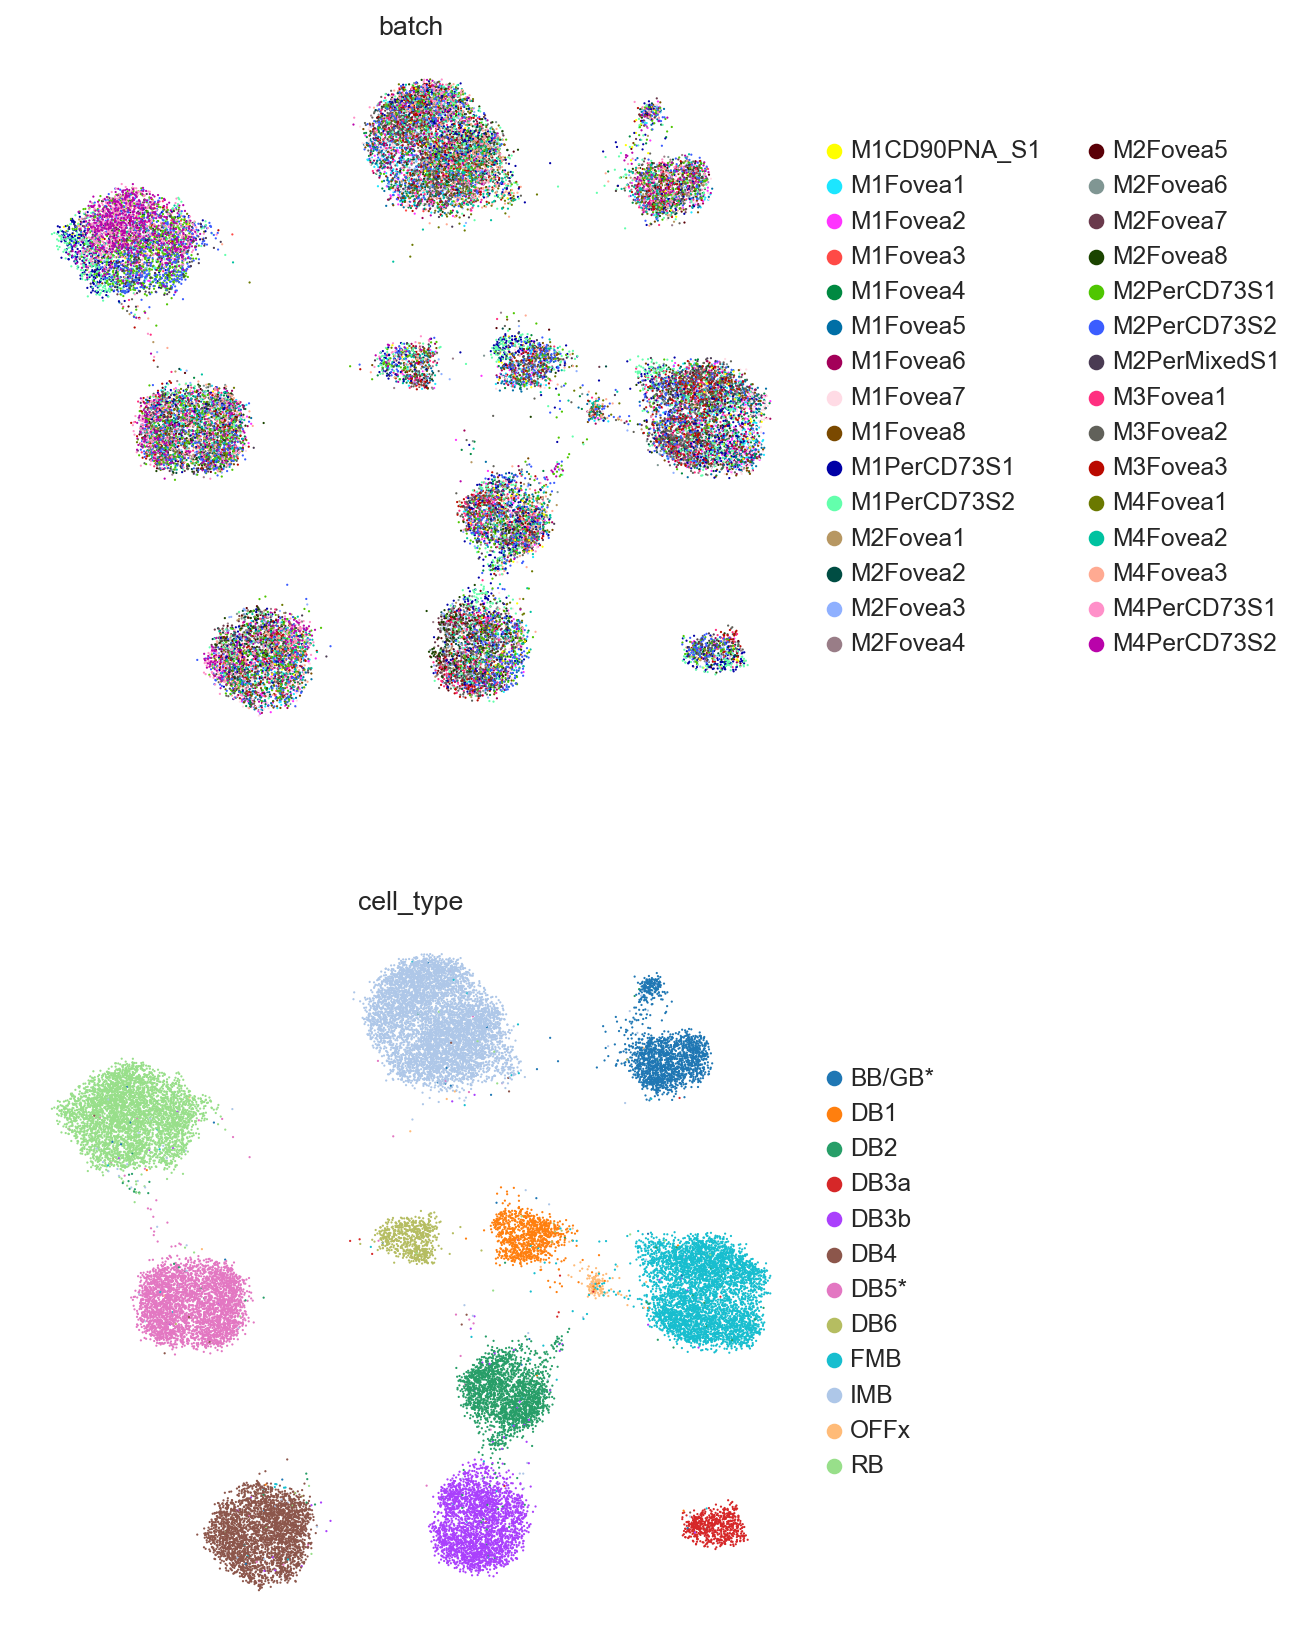

In [11]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [12]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="batch_labels",
    unlabeled_category="Unknown",
)

In [13]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|█| 20/20 [01:46<00:00,  5.66s/it, v_num=1, train_loss_step=394

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [01:46<00:00,  5.31s/it, v_num=1, train_loss_step=394


In [14]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [15]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict['X_scANVI'] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [16]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

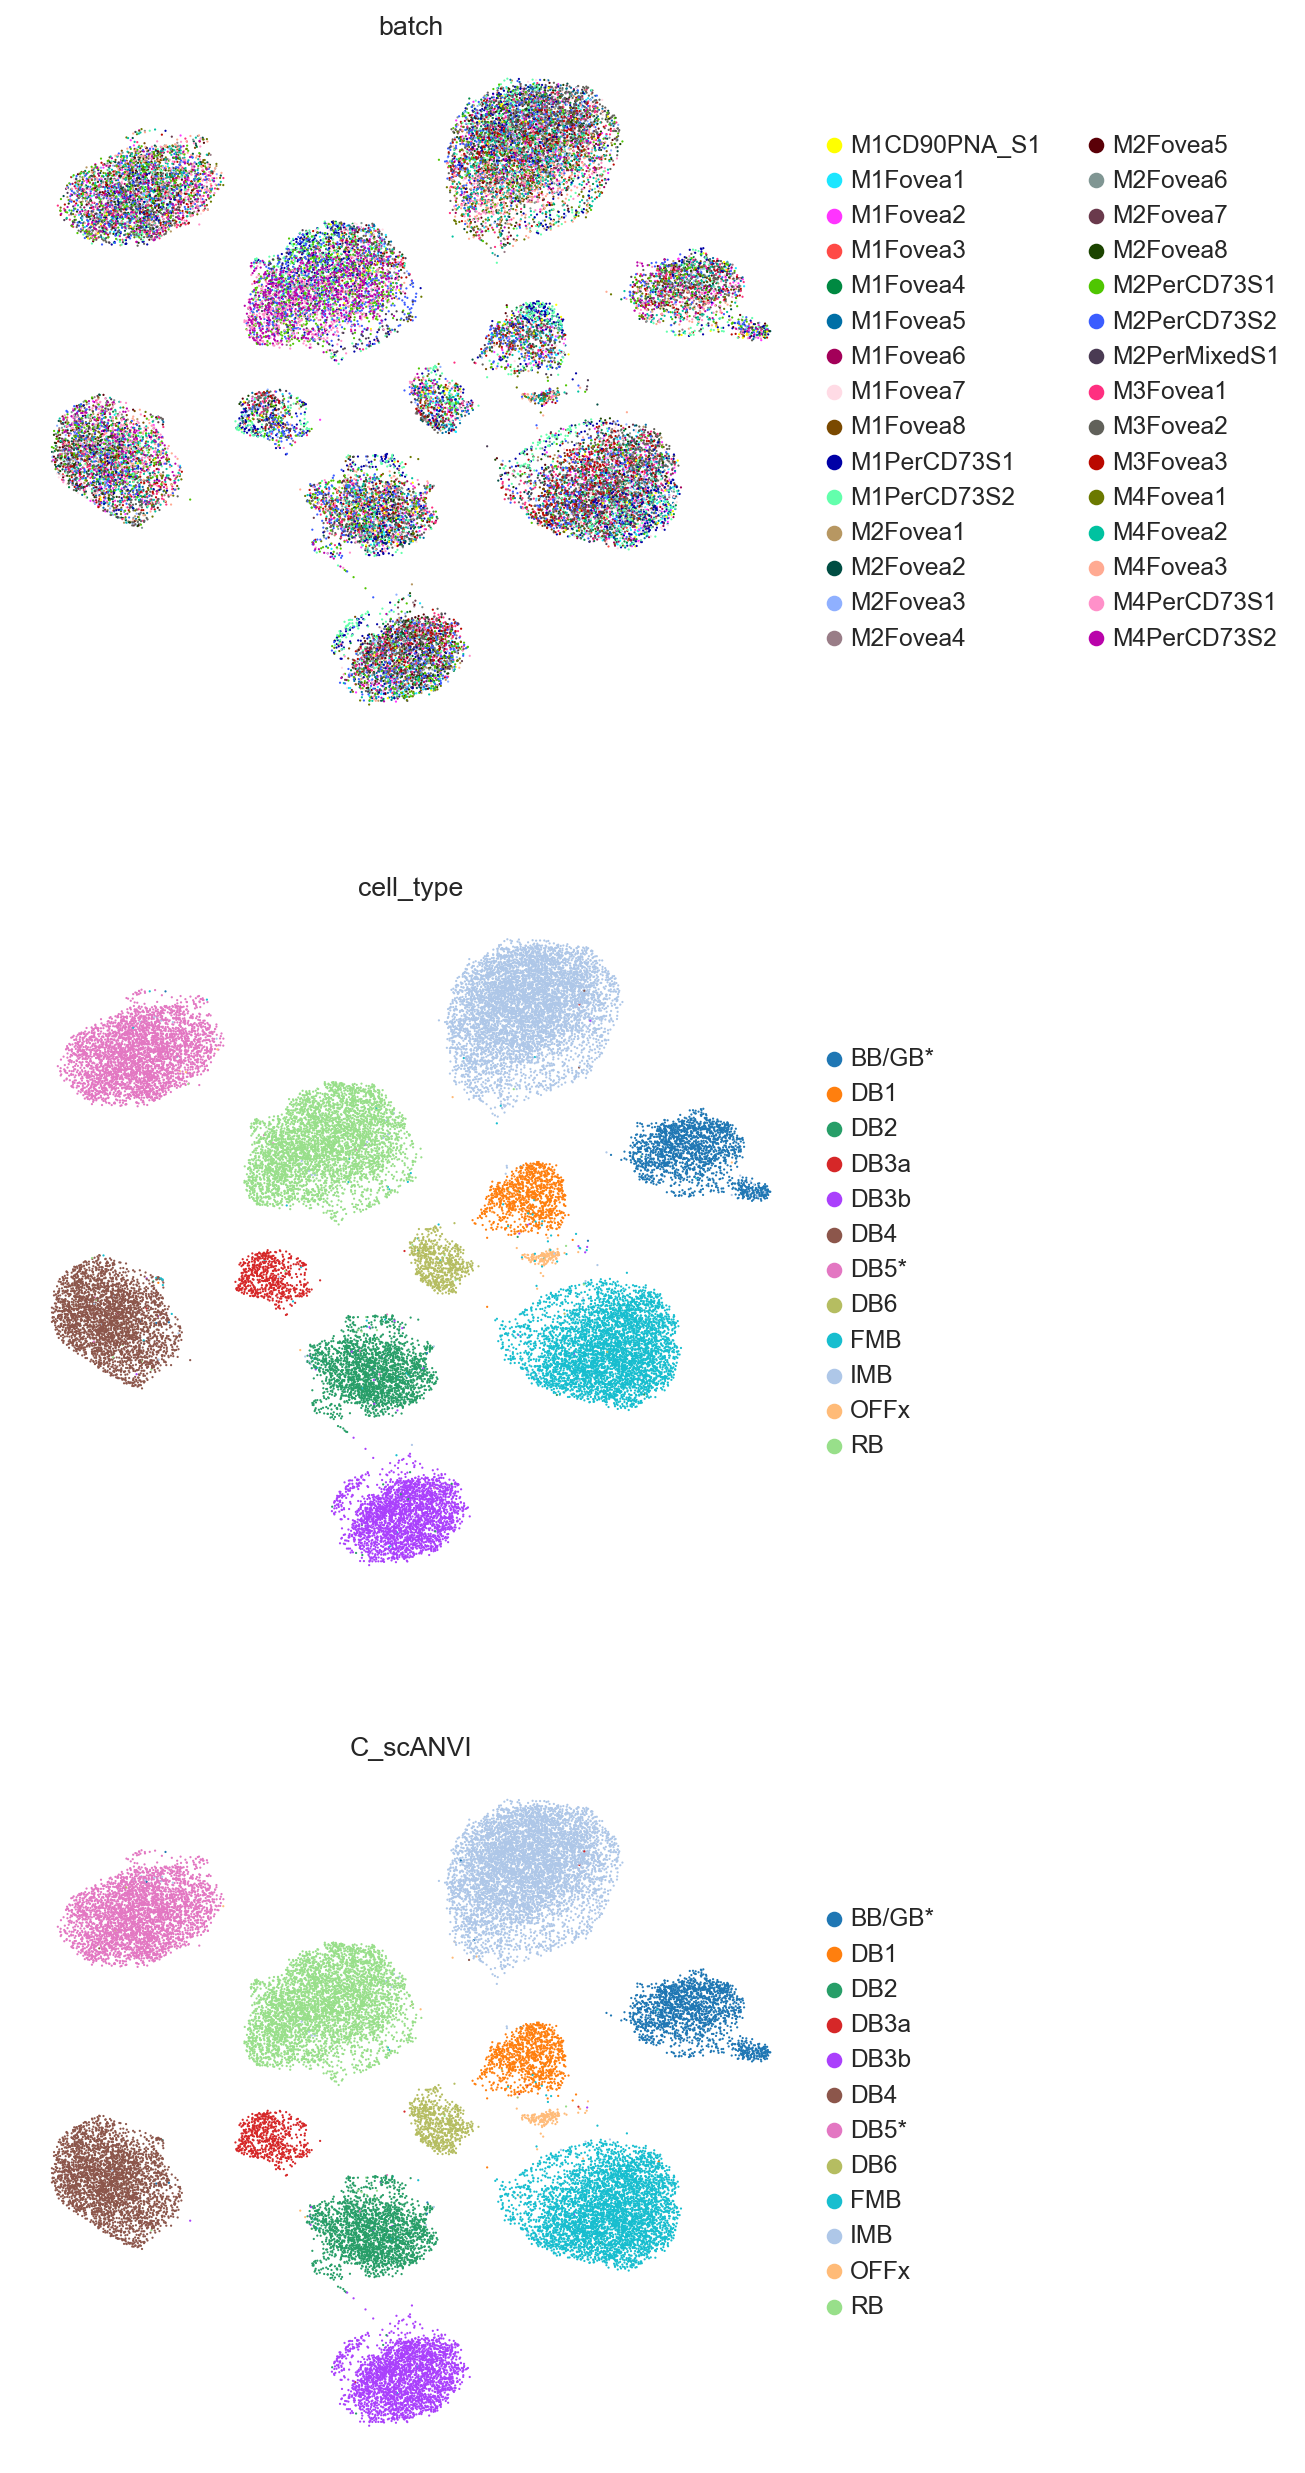

In [17]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [18]:
train = adata.copy()

### Preprocessing Data

In [19]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="batch_labels")

## Creating and Training the model¶

In [20]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 26/100:  26%|▎| 26/100 [47:31<2:15:15, 109.66s/it, v_num=1, train_loss_ste
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1074.021. Signaling Trainer to stop.


## Batch-Removal

In [21]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 30302 × 2000
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH', 'batch_labels', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [22]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [23]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

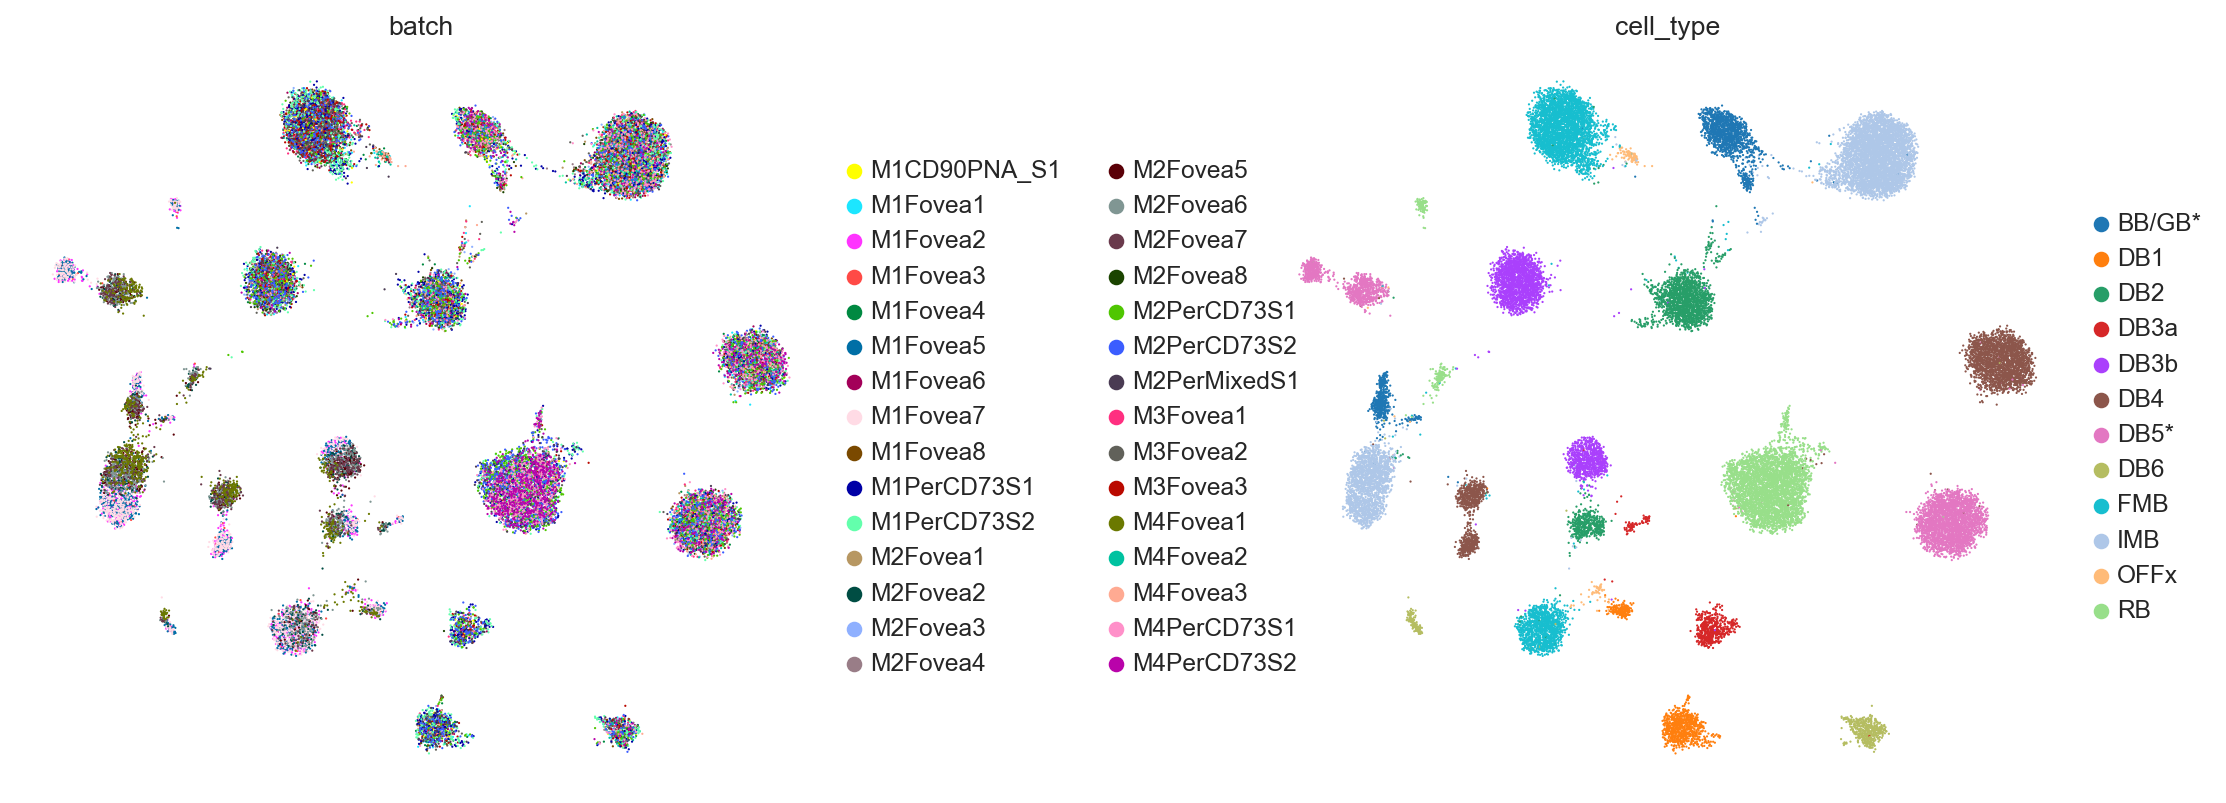

In [24]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [25]:
pca_embeddings = pd.read_csv('../R_macaque/embeddings/macaque_stacas_embeddings_partially_annotated_batches_70.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [26]:
# Collect embeddings
embeddings_dict["X_stacas"] = adata.obsm['X_stacas']

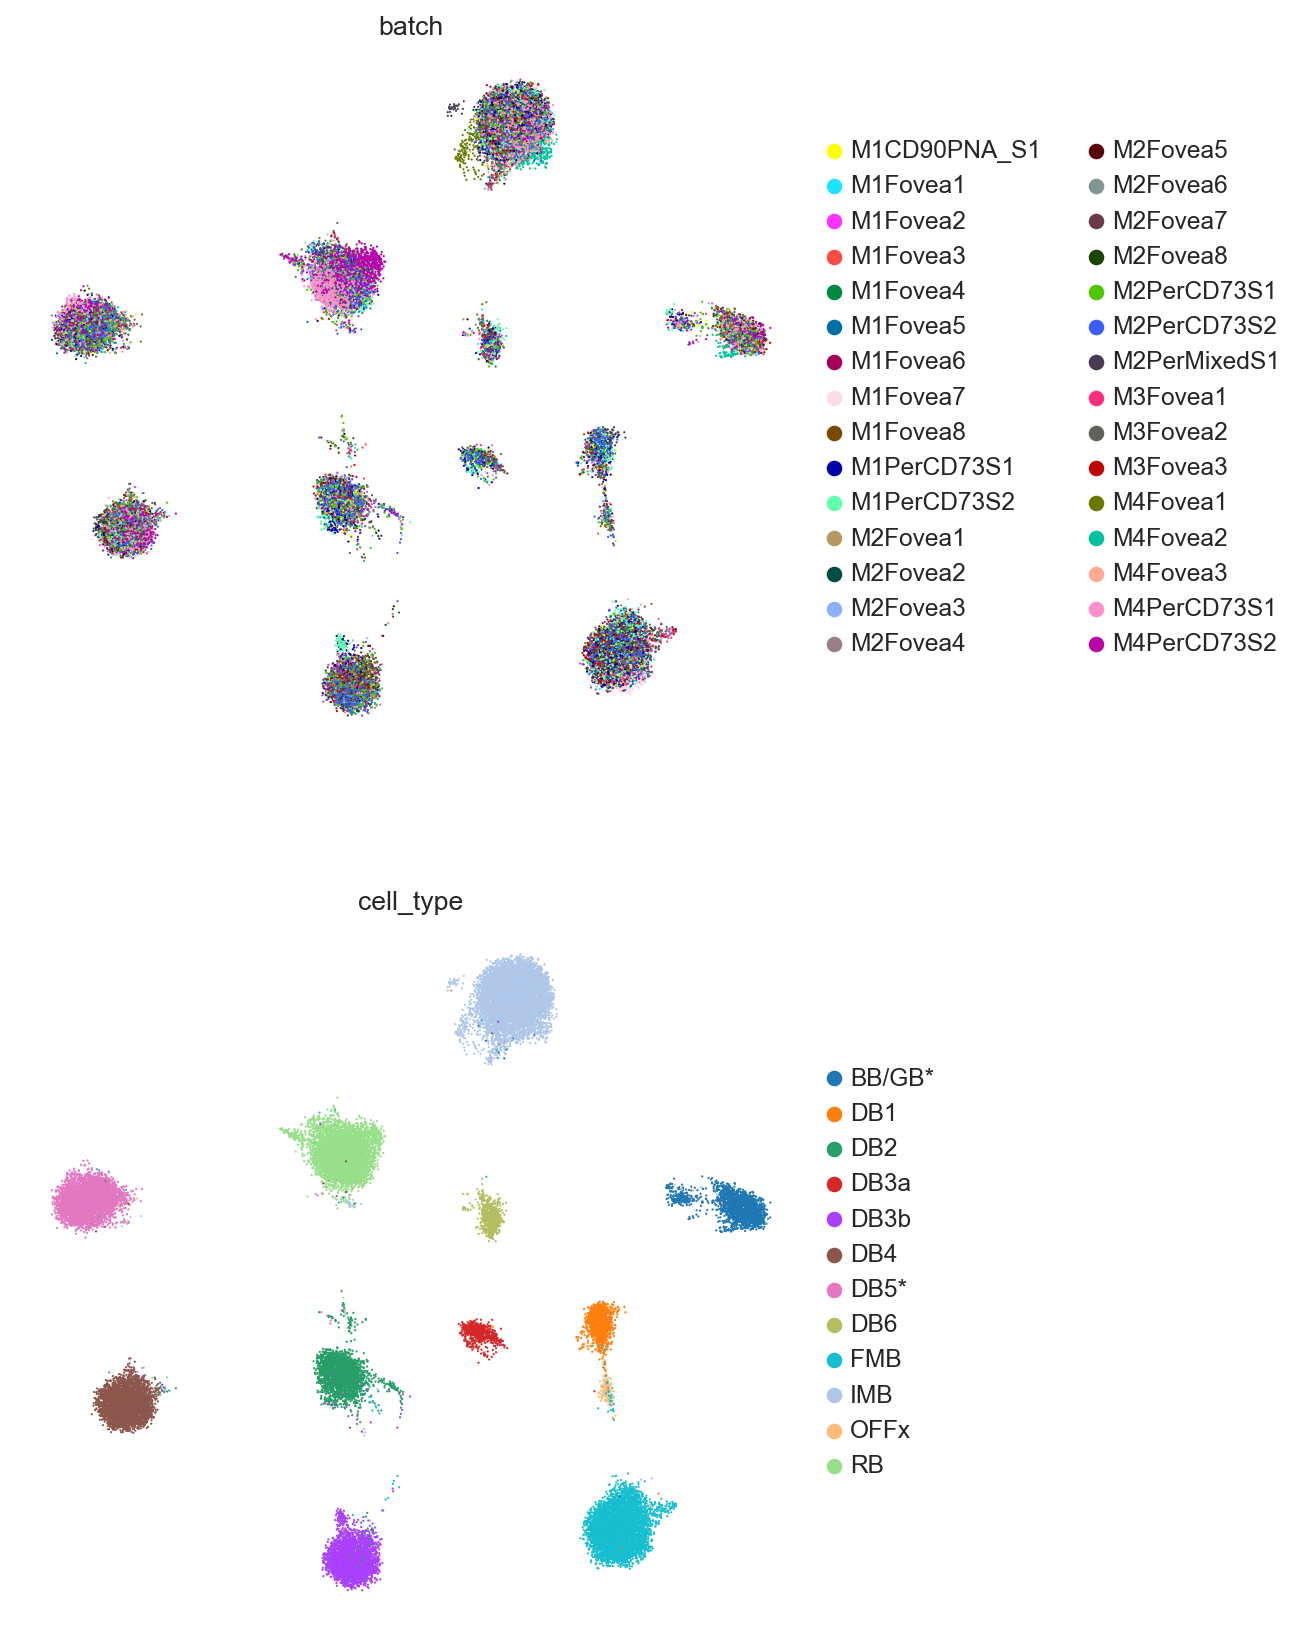

In [27]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [ ]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/partially_annotated_batches_macaque_70.csv")


# Metric Evaluation

## read the embeddings

In [30]:
# Step 1: Read the CSV file into a DataFrame
import pandas as pd

combined_embeddings = pd.read_csv("../embeddings/partially_annotated_batches_macaque_70.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [31]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

resolution: 0.1, nmi: 0.9602800897755469
resolution: 0.2, nmi: 0.9282691644450812
resolution: 0.3, nmi: 0.909678282996064
resolution: 0.4, nmi: 0.8964803890663506
resolution: 0.5, nmi: 0.8968844102289542
resolution: 0.6, nmi: 0.8902963289395626
resolution: 0.7, nmi: 0.8912658222366492
resolution: 0.8, nmi: 0.8831662287683724
resolution: 0.9, nmi: 0.8831088546424473
resolution: 1.0, nmi: 0.8811201676275251
resolution: 1.1, nmi: 0.8810086799172618
resolution: 1.2, nmi: 0.8812166135969741
resolution: 1.3, nmi: 0.8806822962999098
resolution: 1.4, nmi: 0.8682484459751539
resolution: 1.5, nmi: 0.8660224103480822
resolution: 1.6, nmi: 0.8596844318022036
resolution: 1.7, nmi: 0.8467149350831263
resolution: 1.8, nmi: 0.8544684676738648
resolution: 1.9, nmi: 0.833806502323851
resolution: 2.0, nmi: 0.8290346214616598
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.9602800897755469
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on 

In [32]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

resolution: 0.1, nmi: 0.7799182963145671
resolution: 0.2, nmi: 0.8302564756634861
resolution: 0.3, nmi: 0.818537226174509
resolution: 0.4, nmi: 0.78256031242833
resolution: 0.5, nmi: 0.7652497245078302
resolution: 0.6, nmi: 0.7684757090095223
resolution: 0.7, nmi: 0.7684617169678724
resolution: 0.8, nmi: 0.7472620036051667
resolution: 0.9, nmi: 0.7487148664778732
resolution: 1.0, nmi: 0.7455241362915476
resolution: 1.1, nmi: 0.7553058569533829
resolution: 1.2, nmi: 0.7648097306964685
resolution: 1.3, nmi: 0.7601588280573491
resolution: 1.4, nmi: 0.764481200782476
resolution: 1.5, nmi: 0.7700186254486245
resolution: 1.6, nmi: 0.7724333612820953
resolution: 1.7, nmi: 0.7604300908822825
resolution: 1.8, nmi: 0.7609082874133577
resolution: 1.9, nmi: 0.7609024968927155
resolution: 2.0, nmi: 0.7613328034324276
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.8302564756634861
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on re

In [33]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

resolution: 0.1, nmi: 0.941399540101733
resolution: 0.2, nmi: 0.8989824810073487
resolution: 0.3, nmi: 0.8508495084329559
resolution: 0.4, nmi: 0.8507823366258812
resolution: 0.5, nmi: 0.8369743545860355
resolution: 0.6, nmi: 0.8370056572339039
resolution: 0.7, nmi: 0.8319323001039521
resolution: 0.8, nmi: 0.821039220623912
resolution: 0.9, nmi: 0.8130018291913345
resolution: 1.0, nmi: 0.8101291841005959
resolution: 1.1, nmi: 0.7928598320413592
resolution: 1.2, nmi: 0.7965123547781233
resolution: 1.3, nmi: 0.7919480007423055
resolution: 1.4, nmi: 0.7834862110510453
resolution: 1.5, nmi: 0.7780678299513037
resolution: 1.6, nmi: 0.7750577168917518
resolution: 1.7, nmi: 0.7705772080697981
resolution: 1.8, nmi: 0.7709125426239276
resolution: 1.9, nmi: 0.7686578209274817
resolution: 2.0, nmi: 0.7652048348735264
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.941399540101733
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on r

In [34]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df.to_csv("../metrics/macaque_metrics_partially_annotated_batches_70.csv", index=True)

In [35]:
merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.974258,0.808208,0.941627
ARI_cluster/label,0.984149,0.662036,0.951656
ASW_label,0.690977,0.535349,0.619904
ASW_label/batch,0.930165,0.936908,0.919738
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.981873,0.850134,0.961958
isolated_label_silhouette,0.685920,0.541372,0.616306
graph_conn,0.997366,0.992396,0.993543
kBET,NaN,NaN,NaN
